
# COMPARACIÓN DE TÉCNICAS DE OPTIMIZACIÓN DE HIPERPARÁMETROS
( Grid Search vs Random Search vs Optuna)




## 1. INSTALACIÓN DE DEPENDENCIAS

In [17]:
!pip install optuna

## 2. IMPORTACIÓN DE LIBRERÍAS

In [18]:
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

# PARTE 0: CARGA Y PREPARACIÓN DE DATOS (SIN FUGA)

In [19]:

print("=" * 80)
print("CARGA Y PREPARACIÓN DE DATOS")
print("=" * 80)

# Cargar dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print(f"\nDataset cargado:")
print(f"  • Muestras: {X.shape[0]}")
print(f"  • Características: {X.shape[1]}")
print(f"  • Distribución: {y.value_counts().to_dict()}")

# Split + Escalado sin fuga
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nDivisión (70/30):")
print(f"  • Train: {X_train_scaled.shape[0]} muestras")
print(f"  • Test: {X_test_scaled.shape[0]} muestras")


CARGA Y PREPARACIÓN DE DATOS

Dataset cargado:
  • Muestras: 569
  • Características: 30
  • Distribución: {1: 357, 0: 212}

División (70/30):
  • Train: 398 muestras
  • Test: 171 muestras


# PARTE 1: MODELO BASE

In [20]:
print("\n" + "=" * 80)
print("PARTE 1: MODELO BASE (SIN AJUSTE)")
print("=" * 80)

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_base.fit(X_train_scaled, y_train)

y_pred_base = rf_base.predict(X_test_scaled)
f1_base = f1_score(y_test, y_pred_base)
acc_base = accuracy_score(y_test, y_pred_base)

print(f"\nRendimiento del modelo base:")
print(f"  • F1-Score: {f1_base:.4f}")
print(f"  • Accuracy: {acc_base:.4f}")



PARTE 1: MODELO BASE (SIN AJUSTE)

Rendimiento del modelo base:
  • F1-Score: 0.9488
  • Accuracy: 0.9357


# PARTE 2: GRID SEARCH

In [21]:
print("\n" + "=" * 80)
print("PARTE 2: GRID SEARCH")
print("=" * 80)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

print(f"\nEspacio de búsqueda:")
print(f"  • n_estimators: {param_grid['n_estimators']}")
print(f"  • max_depth: {param_grid['max_depth']}")
print(f"  • min_samples_split: {param_grid['min_samples_split']}")
print(f"  • Total combinaciones: {3 * 3 * 3} = 27")

print(f"\nEjecutando Grid Search (cv=3)...")
inicio_gs = time.time()

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
tiempo_gs = time.time() - inicio_gs

print(f"Tiempo de ejecución: {tiempo_gs:.2f} segundos")
print(f"\nMejores parámetros:")
print(f"  • {grid_search.best_params_}")
print(f"  • F1-Score en CV: {grid_search.best_score_:.4f}")

y_pred_gs = grid_search.predict(X_test_scaled)
f1_gs = f1_score(y_test, y_pred_gs)
acc_gs = accuracy_score(y_test, y_pred_gs)

print(f"\nRendimiento en test:")
print(f"  • F1-Score: {f1_gs:.4f}")
print(f"  • Accuracy: {acc_gs:.4f}")



PARTE 2: GRID SEARCH

Espacio de búsqueda:
  • n_estimators: [50, 100, 200]
  • max_depth: [5, 10, 15]
  • min_samples_split: [2, 5, 10]
  • Total combinaciones: 27 = 27

Ejecutando Grid Search (cv=3)...
Tiempo de ejecución: 39.55 segundos

Mejores parámetros:
  • {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
  • F1-Score en CV: 0.9761

Rendimiento en test:
  • F1-Score: 0.9439
  • Accuracy: 0.9298


# PARTE 3: RANDOM SEARCH

In [22]:
print("\n" + "=" * 80)
print("PARTE 3: RANDOM SEARCH")
print("=" * 80)

param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [3, 5, 7, 10, 15, 20],
    'min_samples_split': [2, 3, 5, 10, 15, 20]
}

print(f"\nDistribuciones de búsqueda:")
print(f"  • n_estimators: {param_dist['n_estimators']}")
print(f"  • max_depth: {param_dist['max_depth']}")
print(f"  • min_samples_split: {param_dist['min_samples_split']}")
print(f"  • Iteraciones: 20")

print(f"\nEjecutando Random Search (cv=3)...")
inicio_rs = time.time()

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_dist,
    n_iter=20,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)
tiempo_rs = time.time() - inicio_rs

print(f"Tiempo de ejecución: {tiempo_rs:.2f} segundos")
print(f"\nMejores parámetros:")
print(f"  • {random_search.best_params_}")
print(f"  • F1-Score en CV: {random_search.best_score_:.4f}")

y_pred_rs = random_search.predict(X_test_scaled)
f1_rs = f1_score(y_test, y_pred_rs)
acc_rs = accuracy_score(y_test, y_pred_rs)

print(f"\nRendimiento en test:")
print(f"  • F1-Score: {f1_rs:.4f}")
print(f"  • Accuracy: {acc_rs:.4f}")



PARTE 3: RANDOM SEARCH

Distribuciones de búsqueda:
  • n_estimators: [50, 100, 150, 200, 250, 300]
  • max_depth: [3, 5, 7, 10, 15, 20]
  • min_samples_split: [2, 3, 5, 10, 15, 20]
  • Iteraciones: 20

Ejecutando Random Search (cv=3)...
Tiempo de ejecución: 31.12 segundos

Mejores parámetros:
  • {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 15}
  • F1-Score en CV: 0.9761

Rendimiento en test:
  • F1-Score: 0.9439
  • Accuracy: 0.9298


# PARTE 4: OPTUNA

In [23]:
print("\n" + "=" * 80)
print("PARTE 4: OPTUNA (OPTIMIZACIÓN BAYESIANA)")
print("=" * 80)

print(f"\nEspacio de búsqueda:")
print(f"  • n_estimators: [10, 300]")
print(f"  • max_depth: [2, 25]")
print(f"  • min_samples_split: [2, 20]")
print(f"  • Iteraciones: 20")
print(f"  • Algoritmo: TPE (Tree Parzen Estimator)")



PARTE 4: OPTUNA (OPTIMIZACIÓN BAYESIANA)

Espacio de búsqueda:
  • n_estimators: [10, 300]
  • max_depth: [2, 25]
  • min_samples_split: [2, 20]
  • Iteraciones: 20
  • Algoritmo: TPE (Tree Parzen Estimator)


In [24]:

# Definir función objetivo para Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20)
    }

    rf = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)

    y_pred = rf.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    return f1



In [33]:
# Crear estudio Optuna con TPESampler

inicio_optuna = time.time()

sampler = TPESampler(seed=42)
study = optuna.create_study(
    direction='maximize',
    sampler=sampler,
    pruner=MedianPruner()
)



[I 2025-10-14 21:50:23,087] A new study created in memory with name: no-name-589e7554-22ab-4f3a-92d3-3070e42ed291


In [26]:
# Ejecutar optimización
study.optimize(objective, n_trials=20, show_progress_bar=False)
tiempo_optuna = time.time() - inicio_optuna

print(f"Tiempo de ejecución: {tiempo_optuna:.2f} segundos")
print(f"\nMejores parámetros:")
best_params_optuna = study.best_params
print(f"  • {best_params_optuna}")
print(f"  • F1-Score: {study.best_value:.4f}")

[I 2025-10-14 21:48:57,166] Trial 0 finished with value: 0.9439252336448598 and parameters: {'n_estimators': 118, 'max_depth': 24, 'min_samples_split': 15}. Best is trial 0 with value: 0.9439252336448598.
[I 2025-10-14 21:48:57,983] Trial 1 finished with value: 0.9537037037037037 and parameters: {'n_estimators': 184, 'max_depth': 5, 'min_samples_split': 4}. Best is trial 1 with value: 0.9537037037037037.
[I 2025-10-14 21:48:58,117] Trial 2 finished with value: 0.9439252336448598 and parameters: {'n_estimators': 26, 'max_depth': 22, 'min_samples_split': 13}. Best is trial 1 with value: 0.9537037037037037.
[I 2025-10-14 21:48:58,930] Trial 3 finished with value: 0.9439252336448598 and parameters: {'n_estimators': 216, 'max_depth': 2, 'min_samples_split': 20}. Best is trial 1 with value: 0.9537037037037037.
[I 2025-10-14 21:48:59,803] Trial 4 finished with value: 0.9537037037037037 and parameters: {'n_estimators': 252, 'max_depth': 7, 'min_samples_split': 5}. Best is trial 1 with value: 0

Tiempo de ejecución: 11.30 segundos

Mejores parámetros:
  • {'n_estimators': 184, 'max_depth': 5, 'min_samples_split': 4}
  • F1-Score: 0.9537


In [27]:
# Entrenar modelo final con Optuna
rf_optuna = RandomForestClassifier(**best_params_optuna, random_state=42, n_jobs=-1)
rf_optuna.fit(X_train_scaled, y_train)

y_pred_optuna = rf_optuna.predict(X_test_scaled)
f1_optuna = f1_score(y_test, y_pred_optuna)
acc_optuna = accuracy_score(y_test, y_pred_optuna)

print(f"\nRendimiento en test:")
print(f"  • F1-Score: {f1_optuna:.4f}")
print(f"  • Accuracy: {acc_optuna:.4f}")



Rendimiento en test:
  • F1-Score: 0.9537
  • Accuracy: 0.9415


# PARTE 5: COMPARACIÓN COMPLETA

In [29]:
print("\n" + "=" * 80)
print("PARTE 5: COMPARACIÓN COMPLETA DE TÉCNICAS")
print("=" * 80)

comparacion = pd.DataFrame({
    'Técnica': ['Modelo Base', 'Grid Search', 'Random Search', 'Optuna'],
    'F1-Score': [f1_base, f1_gs, f1_rs, f1_optuna],
    'Accuracy': [acc_base, acc_gs, acc_rs, acc_optuna],
    'Tiempo (seg)': [0, tiempo_gs, tiempo_rs, tiempo_optuna]
})

print(f"\n{comparacion.to_string(index=False)}")

print(f"\n\nMejora respecto al modelo base (%):")
print(f"  • Grid Search: +{((f1_gs - f1_base) / f1_base * 100):.2f}%")
print(f"  • Random Search: +{((f1_rs - f1_base) / f1_base * 100):.2f}%")
print(f"  • Optuna: +{((f1_optuna - f1_base) / f1_base * 100):.2f}%")

print(f"\nEficiencia (F1-Score por segundo):")
print(f"  • Grid Search: {f1_gs / tiempo_gs:.4f}")
print(f"  • Random Search: {f1_rs / tiempo_rs:.4f}")
print(f"  • Optuna: {f1_optuna / tiempo_optuna:.4f}")



PARTE 5: COMPARACIÓN COMPLETA DE TÉCNICAS

      Técnica  F1-Score  Accuracy  Tiempo (seg)
  Modelo Base  0.948837  0.935673      0.000000
  Grid Search  0.943925  0.929825     39.550336
Random Search  0.943925  0.929825     31.122733
       Optuna  0.953704  0.941520     11.297757


Mejora respecto al modelo base (%):
  • Grid Search: +-0.52%
  • Random Search: +-0.52%
  • Optuna: +0.51%

Eficiencia (F1-Score por segundo):
  • Grid Search: 0.0239
  • Random Search: 0.0303
  • Optuna: 0.0844


# PARTE 6: VISUALIZACIONES


PARTE 6: VISUALIZACIONES


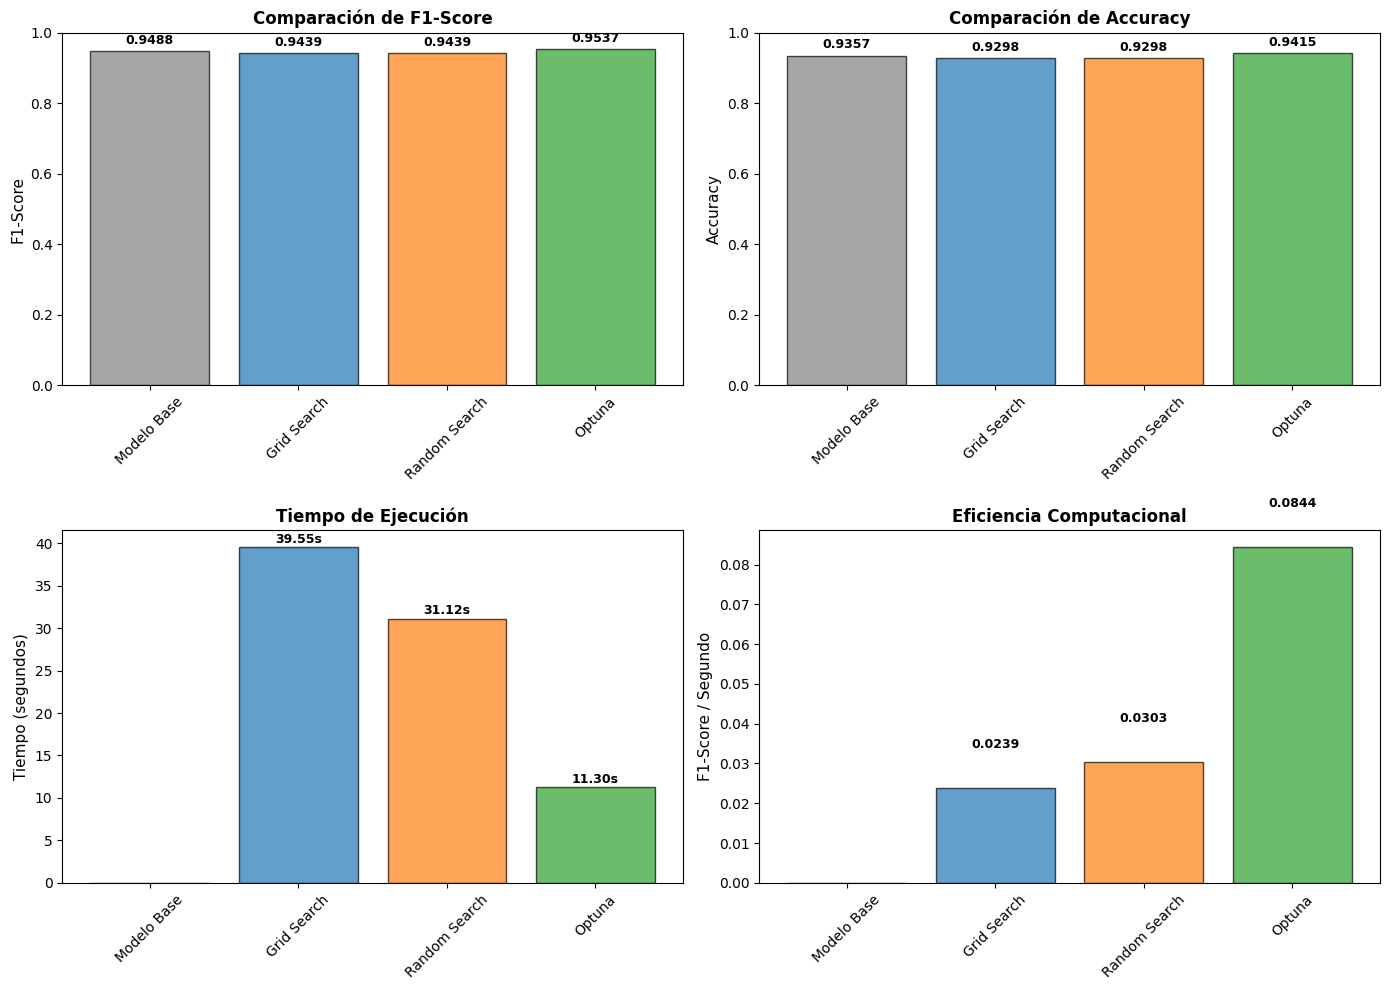

In [30]:
print("\n" + "=" * 80)
print("PARTE 6: VISUALIZACIONES")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: F1-Score
ax = axes[0, 0]
colores = ['gray', '#1f77b4', '#ff7f0e', '#2ca02c']
ax.bar(comparacion['Técnica'], comparacion['F1-Score'], color=colores, alpha=0.7, edgecolor='black')
ax.set_ylabel('F1-Score', fontsize=11)
ax.set_title('Comparación de F1-Score', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])
for i, v in enumerate(comparacion['F1-Score']):
    ax.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=9)
ax.tick_params(axis='x', rotation=45)

# Gráfico 2: Accuracy
ax = axes[0, 1]
ax.bar(comparacion['Técnica'], comparacion['Accuracy'], color=colores, alpha=0.7, edgecolor='black')
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Comparación de Accuracy', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])
for i, v in enumerate(comparacion['Accuracy']):
    ax.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=9)
ax.tick_params(axis='x', rotation=45)

# Gráfico 3: Tiempo de ejecución
ax = axes[1, 0]
ax.bar(comparacion['Técnica'], comparacion['Tiempo (seg)'], color=colores, alpha=0.7, edgecolor='black')
ax.set_ylabel('Tiempo (segundos)', fontsize=11)
ax.set_title('Tiempo de Ejecución', fontsize=12, fontweight='bold')
for i, v in enumerate(comparacion['Tiempo (seg)']):
    if v > 0:
        ax.text(i, v + 0.5, f'{v:.2f}s', ha='center', fontweight='bold', fontsize=9)
ax.tick_params(axis='x', rotation=45)

# Gráfico 4: Eficiencia (F1 por segundo)
ax = axes[1, 1]
eficiencia = [0, f1_gs/tiempo_gs, f1_rs/tiempo_rs, f1_optuna/tiempo_optuna]
ax.bar(comparacion['Técnica'], eficiencia, color=colores, alpha=0.7, edgecolor='black')
ax.set_ylabel('F1-Score / Segundo', fontsize=11)
ax.set_title('Eficiencia Computacional', fontsize=12, fontweight='bold')
for i, v in enumerate(eficiencia):
    if v > 0:
        ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold', fontsize=9)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('comparacion_tecnicas_optimizacion.png', dpi=100, bbox_inches='tight')
plt.show()


# PARTE 7: HISTORIAL DE OPTUNA


Historial de iteraciones de Optuna (últimas 5):
--------------------------------------------------------------------------------
    number     value  params_n_estimators  params_max_depth  \
10      10  0.943925                  287                 2   
11      11  0.948837                  251                 6   
12      12  0.943925                  207                14   
13      13  0.948837                  299                 6   
14      14  0.948837                  193                12   
15      15  0.953704                  245                 5   
16      16  0.948837                  252                12   
17      17  0.943925                   97                 4   
18      18  0.953704                  167                 9   
19      19  0.943925                  183                17   

    params_min_samples_split  
10                         2  
11                         7  
12                         5  
13                         8  
14                   

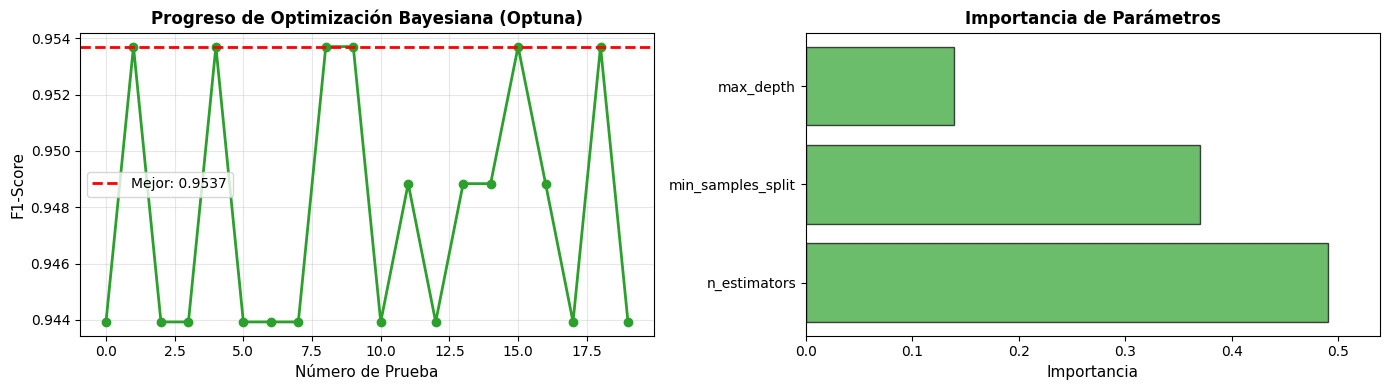

In [31]:
print("\nHistorial de iteraciones de Optuna (últimas 5):")
print("-" * 80)

trials_df = study.trials_dataframe()
print(trials_df[['number', 'value', 'params_n_estimators', 'params_max_depth', 'params_min_samples_split']].tail(10))

# Gráfico de progreso de Optuna
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Progreso de optimización
ax = axes[0]
trial_values = [trial.value if trial.value is not None else 0 for trial in study.trials]
ax.plot(trial_values, marker='o', linestyle='-', linewidth=2, markersize=6, color='#2ca02c')
ax.axhline(y=max(trial_values), color='red', linestyle='--', linewidth=2, label=f'Mejor: {max(trial_values):.4f}')
ax.set_xlabel('Número de Prueba', fontsize=11)
ax.set_ylabel('F1-Score', fontsize=11)
ax.set_title('Progreso de Optimización Bayesiana (Optuna)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Importancia de parámetros
ax = axes[1]
try:
    importances = optuna.importance.get_param_importances(study)
    params = list(importances.keys())
    values = list(importances.values())
    ax.barh(params, values, color='#2ca02c', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Importancia', fontsize=11)
    ax.set_title('Importancia de Parámetros', fontsize=12, fontweight='bold')
    ax.set_xlim([0, max(values) * 1.1])
except:
    ax.text(0.5, 0.5, 'No hay datos suficientes', ha='center', va='center')

plt.tight_layout()
plt.savefig('progreso_optuna.png', dpi=100, bbox_inches='tight')
plt.show()


# PARTE 8: REFLEXIÓN Y CONCLUSIONES

In [32]:

print("\n" + "=" * 80)
print("CONCLUSIONES Y REFLEXIONES")
print("=" * 80)

mejor_tecnica = comparacion.loc[comparacion['F1-Score'].idxmax(), 'Técnica']
mejor_f1 = comparacion['F1-Score'].max()

print(f"""
1. RENDIMIENTO (F1-Score):
   • Mejor técnica: {mejor_tecnica} (F1: {mejor_f1:.4f})
   • Mejora sobre modelo base: +{((mejor_f1 - f1_base) / f1_base * 100):.2f}%

2. EFICIENCIA COMPUTACIONAL:
   • Grid Search es exhaustivo pero lento (27 combinaciones × 3 CV)
   • Random Search es más rápido que Grid Search
   • Optuna es inteligente: usa información anterior para guiar búsqueda

3. CARACTERÍSTICAS DE CADA TÉCNICA:

   Grid Search:
   ✓ Garantiza exploración completa
   ✗ Muy lento para espacios grandes
   ✗ Curse of dimensionality

   Random Search:
   ✓ Más rápido que Grid Search
   ✓ Explora mejor espacios continuos
   ✗ No usa información de iteraciones anteriores

   Optuna (Optimización Bayesiana):
   ✓ MÁS EFICIENTE: combina velocidad y calidad
   ✓ Usa historia de búsqueda para decisiones inteligentes
   ✓ Escalable a espacios de dimensión alta
   ✓ Pruning automático (detiene pruebas prometedoras)
   ✗ Más complejo de entender inicialmente

4. ¿CUÁNDO USAR CADA TÉCNICA?
   • Grid Search: Espacios pequeños, necesitas exhaustividad
   • Random Search: Primeras exploraciones rápidas
   • Optuna: ⭐ Recomendado para mayoría de casos

5. INSIGHTS IMPORTANTES:
   • Optuna suele encontrar buenos parámetros más rápido
   • La mejora a veces es pequeña, pero el ahorro de tiempo es significativo
   • Visualizar la importancia de parámetros ayuda a entender qué afecta al modelo
   • El overfitting en ajuste de parámetros es real: datos de test vs CV

6. RECOMENDACIÓN FINAL:
   Para problemas de salud: Usar Optuna con:
   • Validación cruzada en el rango de búsqueda
   • Métricas balanceadas (F1-Score, no solo Accuracy)
   • Pruning para evitar evaluaciones innecesarias
   • Comparar métodos en test set independiente
""")

print("=" * 80)



CONCLUSIONES Y REFLEXIONES

1. RENDIMIENTO (F1-Score):
   • Mejor técnica: Optuna (F1: 0.9537)
   • Mejora sobre modelo base: +0.51%

2. EFICIENCIA COMPUTACIONAL:
   • Grid Search es exhaustivo pero lento (27 combinaciones × 3 CV)
   • Random Search es más rápido que Grid Search
   • Optuna es inteligente: usa información anterior para guiar búsqueda

3. CARACTERÍSTICAS DE CADA TÉCNICA:

   Grid Search:
   ✓ Garantiza exploración completa
   ✗ Muy lento para espacios grandes
   ✗ Curse of dimensionality

   Random Search:
   ✓ Más rápido que Grid Search
   ✓ Explora mejor espacios continuos
   ✗ No usa información de iteraciones anteriores

   Optuna (Optimización Bayesiana):
   ✓ MÁS EFICIENTE: combina velocidad y calidad
   ✓ Usa historia de búsqueda para decisiones inteligentes
   ✓ Escalable a espacios de dimensión alta
   ✓ Pruning automático (detiene pruebas prometedoras)
   ✗ Más complejo de entender inicialmente

4. ¿CUÁNDO USAR CADA TÉCNICA?
   • Grid Search: Espacios pequeño